In [110]:
import os
import sys
import wandb
import argparse
import numpy as np


sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../")))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "")))
import torch
import torchvision.transforms as T
import torchvision

from dataloaders.dataloader_cifar10 import get_cifar10
from dataloaders.dataloader_cifar100 import get_cifar100
from utils.eval_metrics import linear_evaluation, get_t_SNE_plot
from models.linear_classifer import LinearClassifier
from models.ssl import  SimSiam, Siamese, Encoder, Predictor

from trainers.train_simsiam import train_simsiam
from trainers.train_infomax import train_infomax
from trainers.train_barlow import train_barlow

from trainers.train_PFR import train_PFR_simsiam
from trainers.train_PFR_contrastive import train_PFR_contrastive_simsiam
from trainers.train_contrastive import train_contrastive_simsiam
from trainers.train_ering import train_ering_simsiam

from torchsummary import summary
import random
from utils.lr_schedulers import LinearWarmupCosineAnnealingLR, SimSiamScheduler
from utils.eval_metrics import Knn_Validation_cont
from copy import deepcopy
from loss import invariance_loss,CovarianceLoss,ErrorCovarianceLoss
import torch.nn as nn
import time
import torch.nn.functional as F
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

In [2]:
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = torchvision.transforms.functional.gaussian_blur(x,kernel_size=[3,3],sigma=sigma)#kernel size and sigma are open problems but right now seems ok!
        return x


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [3]:
class Args():
    normalization = 'batch'
    weight_standard = False
    same_lr = False
    pretrain_batch_size = 512
    pretrain_warmup_epochs = 10
    pretrain_warmup_lr = 3e-3
    pretrain_base_lr = 0.03
    pretrain_momentum = 0.9
    pretrain_weight_decay = 5e-4
    min_lr = 0.00
    lambdap = 1.0
    appr = 'barlow_PFR'
    knn_report_freq = 10
    cuda_device = 5
    num_workers = 8
    contrastive_ratio = 0.001
    dataset = 'cifar100'
    class_split = [25,25,25,25]
    epochs = [500,500,500,500]
    cov_loss_weight = 1.0
    sim_loss_weight = 250.0
    info_loss = 'invariance'
    lambda_norm = 1.0
    subspace_rate = 0.99
    lambda_param = 5e-3
    bsize = 32
    msize = 150
    proj_hidden = 2048
    proj_out = 2048 #infomax 64
    pred_hidden = 512
    pred_out = 2048



In [4]:
args = Args()

In [5]:
if args.dataset == "cifar10":
        get_dataloaders = get_cifar10
        num_classes=10
elif args.dataset == "cifar100":
    get_dataloaders = get_cifar100
    num_classes=100
assert sum(args.class_split) == num_classes
assert len(args.class_split) == len(args.epochs)

In [6]:
num_worker = args.num_workers
#device
device = torch.device("cpu")
print(device)

cpu


In [7]:
#wandb init
wandb.init(project="CSSL",  entity="yavuz-team",
            mode="disabled",
            config=args,
            name= str(args.dataset) + '-algo' + str(args.appr) + "-e" + str(args.epochs) + "-b" 
            + str(args.pretrain_batch_size) + "-lr" + str(args.pretrain_base_lr)+"-CS"+str(args.class_split))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [8]:
if 'infomax' in args.appr or 'barlow' in args.appr:
    transform = T.Compose([
            T.RandomResizedCrop(size=32, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)]), p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([GaussianBlur()], p=0.5), 
            T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

    transform_prime = T.Compose([
            T.RandomResizedCrop(size=32, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)]), p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([GaussianBlur()], p=0.5), 
            T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

In [9]:
#Dataloaders
print("Creating Dataloaders..")
#Class Based
train_data_loaders, train_data_loaders_knn, test_data_loaders, _, train_data_loaders_linear, train_data_loaders_pure  = get_dataloaders(transform, transform_prime, \
                                    classes=args.class_split, valid_rate = 0.00, batch_size=args.pretrain_batch_size, seed = 0, num_worker= num_worker)
_, train_data_loaders_knn_all, test_data_loaders_all, _, train_data_loaders_linear_all, train_data_loaders_pure_all = get_dataloaders(transform, transform_prime, \
                                        classes=[num_classes], valid_rate = 0.00, batch_size=args.pretrain_batch_size, seed = 0, num_worker= num_worker)


Creating Dataloaders..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = args.normalization, weight_standard = args.weight_standard,appr_name =args.appr)
    model = Siamese(encoder)
    model.to(device) #automatically detects from model

In [11]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algocassle_barlow-e[500, 500, 500, 500]-b256-lr0.06-CS[25, 25, 25, 25]acc_60.97.pth.tar'
dict = torch.load(file_name)

In [12]:
model.temporal_projector = nn.Sequential(
            nn.Linear(args.proj_out, args.proj_hidden, bias=False),
            nn.BatchNorm1d(args.proj_hidden),
            nn.ReLU(),
            nn.Linear(args.proj_hidden, args.proj_out),
        ).to(device)

In [13]:
model.load_state_dict(dict['state_dict'])

<All keys matched successfully>

In [14]:
device

device(type='cpu')

In [15]:
#Test Linear classification acc
print("Starting Classifier Training..")
lin_epoch = 100
if args.dataset == 'cifar10':
    classifier = LinearClassifier(num_classes = 10).to(device)
elif args.dataset == 'cifar100':
    classifier = LinearClassifier(num_classes = 100).to(device)

classifier.load_state_dict(dict['classifier'])

# lin_optimizer = torch.optim.SGD(classifier.parameters(), 0.1, momentum=0.9) # Infomax: no weight decay, epoch 100, cosine scheduler
# lin_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(lin_optimizer, lin_epoch, eta_min=2e-4) #scheduler + values ref: infomax paper
# test_loss, test_acc1, test_acc5, classifier = linear_evaluation(model, train_data_loaders_knn_all[0],
#                                                                     test_data_loaders_all[0],lin_optimizer, classifier, 
#                                                                     lin_scheduler, epochs=lin_epoch, device=device) 


Starting Classifier Training..


<All keys matched successfully>

In [16]:
from tqdm import tqdm
def correct_top_k(outputs, targets, top_k=(1,5)):
    """
    Find number of correct predictions for one batch.
    Args:
        outputs (torch.Tensor): Nx(class_number) Tensor containing logits.
        targets (torch.Tensor): N Tensor containing ground truths.
        top_k (Tuple): checking the ground truth is included in top-k prediction.
    Returns:
        List: List of number of top-1 and top-5 correct predictions.
    """
    with torch.no_grad():
        prediction = torch.argsort(outputs, dim=-1, descending=True)
        result= []
        for k in top_k:
            correct_k = torch.sum((prediction[:, 0:k] == targets.unsqueeze(dim=-1)).any(dim=-1).float()).item() 
            result.append(correct_k)
        return result
def linear_test(net, data_loader, classifier, epoch, device):
    # evaluate model:
    net.eval() # for not update batchnorm
    linear_loss = 0.0
    num = 0
    total_loss, total_correct_1, total_correct_5, total_num, test_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader)
    with torch.no_grad():
        for data_tuple in test_bar:
            data, target = [t.to(device) for t in data_tuple]

            # Forward prop of the model with single augmented batch
            output = net(data)

            # Logits by classifier
            if classifier is not None:  #else net is already a classifier
                output = classifier(output) 

            # Calculate Cross Entropy Loss for batch
            linear_loss = F.cross_entropy(output, target)
            
            # Batchsize for loss and accuracy
            num = data.size(0)
            total_num += num 
            
            # Accumulating loss 
            total_loss += linear_loss.item() * num 
            # Accumulating number of correct predictions 
            correct_top_1, correct_top_5 = correct_top_k(output, target, top_k=(1,5))    
            total_correct_1 += correct_top_1
            total_correct_5 += correct_top_5

            test_bar.set_description('Lin.Test Epoch: [{}] Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}% '
                                     .format(epoch,  total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_5 / total_num * 100
                                             ))
        acc_1 = total_correct_1/total_num*100
        acc_5 = total_correct_5/total_num*100
        wandb.log({" Linear Layer Test Loss ": linear_loss / total_num, " Epoch ": epoch})
        wandb.log({" Linear Layer Test - Acc": acc_1, " Epoch ": epoch})
    return total_loss / total_num, acc_1 , acc_5 

In [17]:
def prediction_table(net, data_loader, classifier, device):
    # evaluate model:
    net.eval() # for not update batchnorm
    res = np.zeros((100,100), dtype=np.int8)
    with torch.no_grad():
        for data_tuple in tqdm(data_loader):
            data, target = [t.to(device) for t in data_tuple]
            # Forward prop of the model with single augmented batch
            output = net(data)
            # Logits by classifier
            if classifier is not None:  #else net is already a classifier
                output = classifier(output) 

            prediction = torch.argsort(output, dim=-1, descending=True)
            prediction = prediction[:,0]
            print(prediction.shape)

            for i, t in enumerate(target):
                res[t][prediction[i]] = res[t][prediction[i]] + 1
    return res

In [21]:
res = prediction_table(model,test_data_loaders_all[0],classifier,device)

  5%|▌         | 1/20 [00:01<00:21,  1.11s/it]

torch.Size([512])
torch.Size([512])
torch.Size([512])


 25%|██▌       | 5/20 [00:01<00:03,  4.51it/s]

torch.Size([512])
torch.Size([512])
torch.Size([512])


 40%|████      | 8/20 [00:01<00:01,  6.53it/s]

torch.Size([512])
torch.Size([512])
torch.Size([512])


 55%|█████▌    | 11/20 [00:02<00:01,  8.41it/s]

torch.Size([512])
torch.Size([512])
torch.Size([512])


 65%|██████▌   | 13/20 [00:02<00:00,  9.30it/s]

torch.Size([512])
torch.Size([512])
torch.Size([512])


 85%|████████▌ | 17/20 [00:02<00:00, 10.43it/s]

torch.Size([512])
torch.Size([512])
torch.Size([512])


 95%|█████████▌| 19/20 [00:02<00:00, 10.76it/s]

torch.Size([512])
torch.Size([272])


100%|██████████| 20/20 [00:02<00:00,  6.71it/s]


In [33]:
dict = {}
preds = np.argsort(res, axis=1)[:, ::-1]
for i in range(100):
    dict[i] = preds[i][1]

In [44]:
count = 0
count_pred = np.sort(res, axis=1)[:, ::-1]
for i in range(100):
    if i == dict[dict[i]]:
        if i//25 == dict[i]//25:
            print(f'({i}, task {i//25}, pred {res[i][dict[i]]}) ({dict[i]}, task {dict[i]//25}, pred {res[dict[i]][i]})')
        else:
            print(f'({i}, task {i//25}, pred {res[i][dict[i]]}) ({dict[i]}, task {dict[i]//25}, pred {res[dict[i]][i]}) ------')
        count+=1
count

(3, task 0, pred 6) (21, task 0, pred 4)
(5, task 0, pred 9) (20, task 0, pred 4)
(7, task 0, pred 9) (24, task 0, pred 5)
(8, task 0, pred 7) (48, task 1, pred 8) ------
(9, task 0, pred 5) (40, task 1, pred 6) ------
(10, task 0, pred 10) (61, task 2, pred 11) ------
(13, task 0, pred 16) (81, task 3, pred 13) ------
(20, task 0, pred 4) (5, task 0, pred 9)
(21, task 0, pred 4) (3, task 0, pred 6)
(24, task 0, pred 5) (7, task 0, pred 9)
(26, task 1, pred 5) (45, task 1, pred 7)
(30, task 1, pred 16) (73, task 2, pred 6) ------
(40, task 1, pred 6) (9, task 0, pred 5) ------
(42, task 1, pred 5) (43, task 1, pred 5)
(43, task 1, pred 5) (42, task 1, pred 5)
(45, task 1, pred 7) (26, task 1, pred 5)
(46, task 1, pred 14) (98, task 3, pred 12) ------
(47, task 1, pred 17) (52, task 2, pred 19) ------
(48, task 1, pred 8) (8, task 0, pred 7) ------
(50, task 2, pred 9) (74, task 2, pred 10)
(52, task 2, pred 19) (47, task 1, pred 17) ------
(55, task 2, pred 9) (72, task 2, pred 6)
(60,

32

In [101]:
def davies_bouldin(net, data_loader, device):
    # evaluate model:
    net.eval() # for not update batchnorm
    res = {}
    for i in range(100):
        res[i] = []
    with torch.no_grad():
        for data_tuple in tqdm(data_loader):
            data, target = [t.to(device) for t in data_tuple]
            # Forward prop of the model with single augmented batch
            output = net(data)
            for i, t in enumerate(target):
                res[int(t)].append(output[i].numpy()) 
    return res

In [102]:
res = davies_bouldin(model,test_data_loaders_all[0],device)

100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


In [106]:
mean_arr = []
dist_arr = []
for i in range(100):
    mean_arr.append(np.mean(np.array(res[i]), axis=0))
    dist_arr.append(np.linalg.norm((np.array(res[i])-mean_arr[i]), axis=1))
mean_arr=np.array(mean_arr)
dist_arr=np.array(dist_arr)

In [107]:
center_dists = euclidean_distances(mean_arr,mean_arr)
cluster_radius = np.mean(dist_arr, axis=1)
# cluster_radius = np.quantile(dist_arr, 0.90, axis=1)
cluster_scores = np.zeros((100,100))
all_scores = []
for i in range(100):
    for j in range(i+1, 100):
        if i == j:
            continue
        cluster_scores[i][j] = (cluster_radius[i]+cluster_radius[j])/center_dists[i][j]
        if j > i:
            all_scores.append((cluster_radius[i]+cluster_radius[j])/center_dists[i][j])


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in float_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in float_scalars
  if sys.path[0] == "":


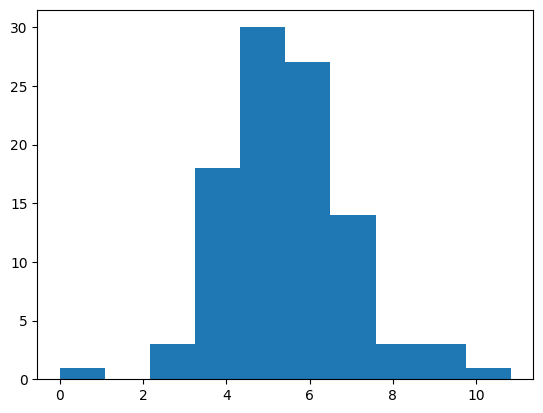

In [92]:
plt.hist(np.max(cluster_scores, axis=1))
plt.show()

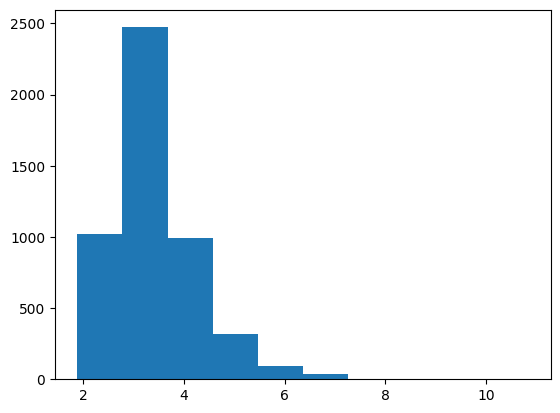

In [93]:
plt.hist(all_scores)
plt.show()

In [111]:
res = davies_bouldin(model,test_data_loaders_all[0],device)
for i in range(100):
    res[i] = np.array(res[1])/np.expand_dims(np.linalg.norm(np.array(res[1]), axis=1), axis=1)

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


In [114]:
mean_arr[i].reshape(-1, 1).shape

(512, 1)

In [124]:
mean_arr = []
dist_arr = []
for i in range(100):
    mean_arr.append(np.mean(np.array(res[i]), axis=0)/np.linalg.norm(np.mean(np.array(res[i]), axis=0)))
    dist_arr.append(cosine_similarity(np.array(res[i]),mean_arr[i].reshape(1, -1)).squeeze())
mean_arr=np.array(mean_arr)
dist_arr=np.array(dist_arr)

In [128]:
center_dists = cosine_similarity(mean_arr,mean_arr)
# cluster_radius = np.mean(dist_arr, axis=1)
cluster_radius = np.quantile(dist_arr, 0.90, axis=1)
cluster_scores = np.zeros((100,100))
all_scores = []
for i in range(100):
    for j in range(i+1, 100):
        if i == j:
            continue
        cluster_scores[i][j] = (cluster_radius[i]+cluster_radius[j])/center_dists[i][j]
        if j > i:
            all_scores.append((cluster_radius[i]+cluster_radius[j])/center_dists[i][j])


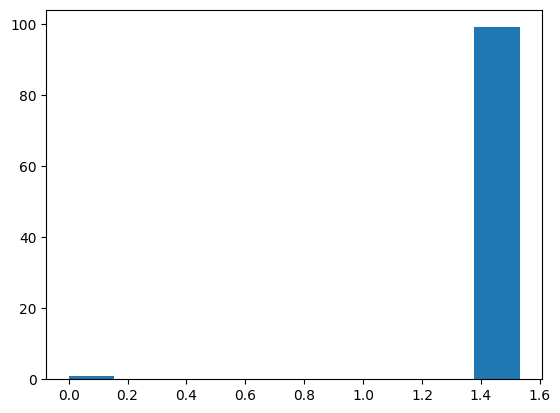

In [129]:
plt.hist(np.max(cluster_scores, axis=1))
plt.show()

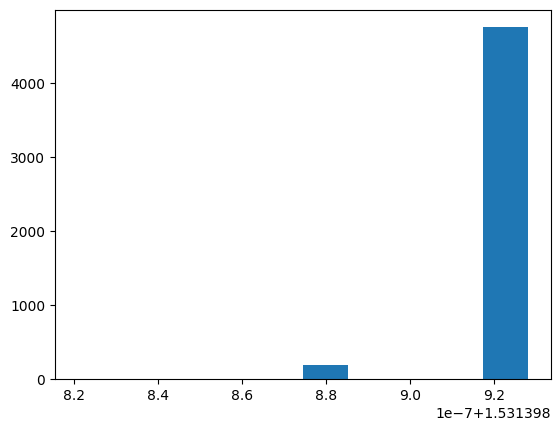

: 

In [130]:
plt.hist(all_scores)
plt.show()